In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import pandas as pd
import datetime
now = datetime.datetime.now

# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading and Preprocessing

In [ ]:
# Load the data
fatigue_df = pd.read_csv('../Data/Carbon_Bending_PI.csv')
fatigue_df

# Removing rows with null values
fatigue_df = fatigue_df.dropna()

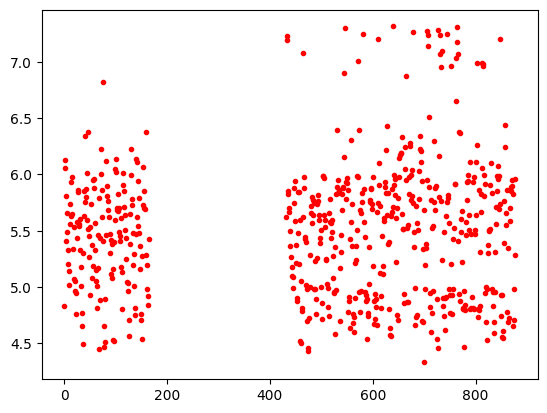

In [ ]:
# Scatter Plot
plt.plot(np.log10(fatigue_df['Number of Cycles']), 'r.')

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

In [ ]:
drop_cols = ['Heat','Number of Cycles','Dataset'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (Mpa),Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,PI Fatigue Life
0,460,650,1270,0.04,0.01,0.00,50.0,29,70,0.42,0.26,0.70,0.024,0.010,0.01,0.01,0.01,2.485278e+04
1,500,550,825,0.11,0.04,0.00,50.0,23,67,0.42,0.22,0.78,0.022,0.020,0.01,0.02,0.03,1.760709e+04
2,470,550,825,0.08,0.00,0.00,50.0,22,68,0.33,0.21,0.75,0.031,0.019,0.01,0.03,0.02,2.601282e+04
3,580,550,825,0.10,0.00,0.00,50.0,22,60,0.54,0.20,0.75,0.013,0.019,0.01,0.01,0.01,1.366745e+04
4,480,550,825,0.11,0.04,0.00,50.0,23,67,0.42,0.22,0.78,0.022,0.020,0.01,0.02,0.03,4.867573e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,520,550,1270,0.08,0.01,0.00,50.0,19,58,0.54,0.26,0.76,0.022,0.021,0.02,0.12,0.01,1.027129e+07
607,480,550,825,0.10,0.00,0.00,50.0,22,60,0.54,0.20,0.75,0.013,0.019,0.01,0.01,0.01,6.859817e+06
608,450,600,1740,0.07,0.00,0.00,50.0,22,64,0.45,0.25,0.79,0.018,0.016,0.02,0.13,0.13,1.484439e+07
609,530,550,610,0.08,0.00,0.04,50.0,16,50,0.54,0.27,0.70,0.017,0.020,0.06,0.10,0.22,1.304105e+07


In [ ]:
# Convert the features into floats
features = features.astype('float64')

# Model Training

In [ ]:
# rmse loss
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

Run # 1 Fold # 1
Training time: 0:01:17.627039


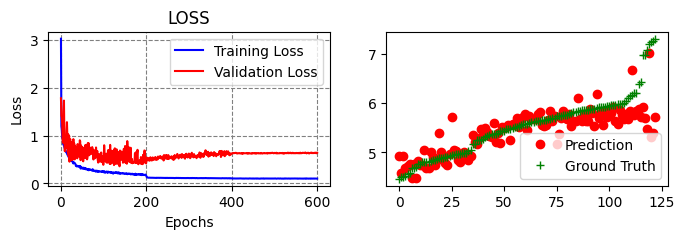

Pearson CC: 0.7624865101637722
R2 score: 0.5468624153047841
RMSE: 0.4135507251572667
MAE: 0.589489368932187
********************
Run # 1 Fold # 2
Training time: 0:01:25.916039


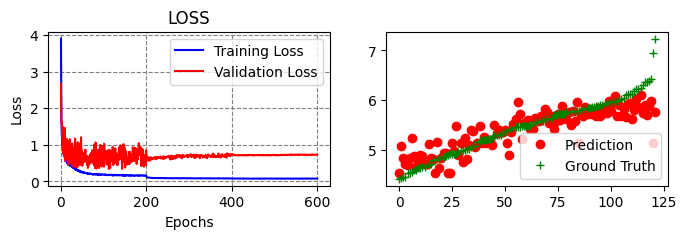

Pearson CC: 0.8242398538637067
R2 score: 0.6635145656022721
RMSE: 0.325748734650225
MAE: 0.5628589998508567
********************
Run # 1 Fold # 3


Training time: 0:01:24.242022


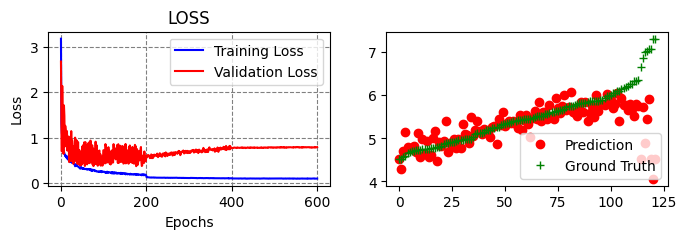

Pearson CC: 0.4417651511130245
R2 score: 0.04382147080500276
RMSE: 0.6146078164854473
MAE: 0.6168465362502533
********************
Run # 1 Fold # 4
Training time: 0:01:20.574081


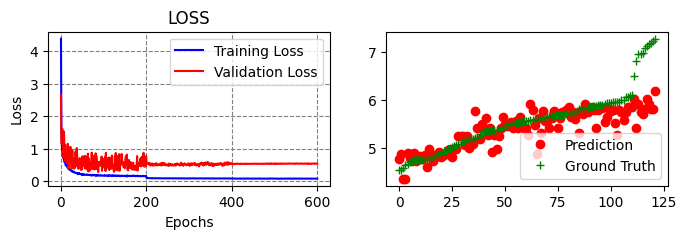

Pearson CC: 0.8044582971550392
R2 score: 0.5578660681239734
RMSE: 0.4155489815161139
MAE: 0.5836987266719105
********************
Run # 1 Fold # 5
Training time: 0:01:18.185834


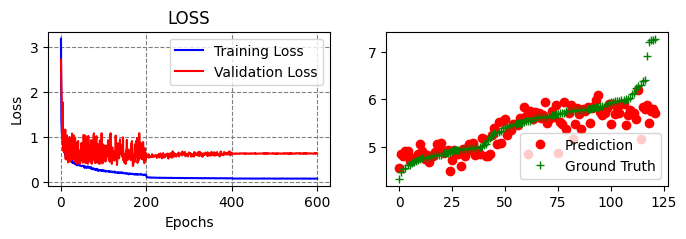

Pearson CC: 0.7815652857444894
R2 score: 0.5656896857867901
RMSE: 0.39454636715740865
MAE: 0.5818443828977737
********************


In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=50+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            # define DNN
            model = Sequential()
            model.add(Input(shape=(18,)))
            model.add(Dense(1000,activation='relu'))
            model.add(Dense(200,activation='relu'))
            model.add(Dense(40,activation='relu'))
            model.add(Dense(1,activation='linear'))

            model.compile(optimizer= 'RMSprop', loss=root_mean_squared_error)

            # learning rate scheduler
            import math
            INITIAL_LEARNING_RATE = 0.01
            EPOCHS_NUM = 600
            def lr_step_decay(epoch, lr):
                drop_rate = 0.1
                epochs_drop = 200
                return INITIAL_LEARNING_RATE * math.pow(drop_rate, math.floor(epoch/epochs_drop))

            callbacks=[LearningRateScheduler(lr_step_decay, verbose=0)]

            # Fit model
            t = now()
            history = model.fit(x_train, y_train, batch_size=16, epochs=EPOCHS_NUM,
                                validation_split=0.2, verbose=0, callbacks=callbacks)
            print('Training time: %s' % (now() - t))

            # Plot the loss and the predictions
            train_loss = history.history['loss']
            val_loss = history.history['val_loss']
            epochsn = np.arange(1, len(train_loss)+1,1)
            plt.figure(figsize=(8, 2))
            plt.subplot(1,2,1)
            plt.plot(epochsn,train_loss, 'b', label='Training Loss')
            plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
            plt.grid(color='gray', linestyle='--')
            plt.legend()
            plt.title('LOSS')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.subplot(1,2,2)
            y_pred_test = model.predict(x_test, verbose=0)
            plt.plot(y_pred_test, 'ro', label='Prediction')
            plt.plot(np.array(y_test), 'g+', label='Ground Truth')
            plt.legend(loc=4)
            plt.show()

            # Evaluate metrics
            PearsonCC[j, i] = pearsonr(y_test, np.squeeze(y_pred_test))[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            print(20*'*')

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.762487,0.546862,0.413551,0.589489
1,0.824240,0.663515,0.325749,0.562859
2,0.441765,0.043821,0.614608,0.616847
3,0.804458,0.557866,0.415549,0.583699
4,0.781565,0.565690,0.394546,0.581844


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.722903,0.142104,0.475551,0.219867,0.432801,0.096587,0.586948,0.01742
